# Trajectory Processing

---

In [1]:
# dependent packages
import pandas as pd
from preprocessing import Preprocess

# 1 Preprocessing

The preprocessing precedure including five steps:
1. Encoding.
2. Trip segmentation.
3. Densification.
4. Calculation.
5. Smoothing.
6. Filtering.

All methods are packed in class `Preprocess` in the module `preprocessing`.  
> - Map-matching is not included in this section. Instead, we stored it in a seperate module `mapmatch` to avoid environment conflict.
> - Due to the data privacy, we can only provide processing procedure with limited samples.

## 1.1 Encoding

Encoding is performed by the function `Preprocess.encode`. In the encoding function, the following operations are supported:
- Set column names.
- Encoding strings as ascending numbers, *e.g.* `vehID` and `orderID`.
- CRS transferring, note that all calculation in this module is based on **WGS84**.
- Sorting by some columns.

In [2]:
raw = pd.read_csv("./data/traj/sample_raw.csv")
raw.head()

,0,1,2,3,4
0,9j22fi9gb62rB4luAgce49ahegf_qBbg,4da2cfjf443wB5eDp6b34honega1xx6n,1477969147,104.07513,30.72724
1,9j22fi9gb62rB4luAgce49ahegf_qBbg,4da2cfjf443wB5eDp6b34honega1xx6n,1477969150,104.07513,30.72702
2,9j22fi9gb62rB4luAgce49ahegf_qBbg,4da2cfjf443wB5eDp6b34honega1xx6n,1477969154,104.07504,30.72672
3,9j22fi9gb62rB4luAgce49ahegf_qBbg,4da2cfjf443wB5eDp6b34honega1xx6n,1477969156,104.07497,30.72630
4,9j22fi9gb62rB4luAgce49ahegf_qBbg,4da2cfjf443wB5eDp6b34honega1xx6n,1477969159,104.07497,30.72582


In [3]:
# initialize a Preprocess object
preprocessor = Preprocess()

# set encode params
preprocessor.setParam(
    funcName='encode',
    paramDict={
        "colName": ['vehID', 'orderID', 'time[s]', 'lon', 'lat'],
        "encodingCol": ['vehID', 'orderID'],
        "sortBy": ['vehID', 'orderID', 'time[s]'],
        "originCRS": 'GCJ02',
    }
)

# perform encoding
traj_encoded = preprocessor.encode(raw)
traj_encoded.head()

Encoding...


,vehID,orderID,time[s],lon,lat
0,0,0,1477969147,104.072604,30.729620
1,0,0,1477969150,104.072604,30.729401
2,0,0,1477969154,104.072514,30.729101
3,0,0,1477969156,104.072444,30.728681
4,0,0,1477969159,104.072444,30.728201


## 1.2 Segmentation

There exist some missing points in a trajectory of a trip, which bring difficulty to the inference of the complete trajctory. Therefore, we divided sequences in the same order at intervals with missing duration longer than a certain length.  

Segmentation is performed by the function `Preprocess.segment`. The default maximum missing interval is set to 6 sec cause it represents a missing of more than two samples (the sampling frequency is 2 to 4 sec).

In [4]:
# set segmentation params
preprocessor.setParam(
    funcName='segment',
    paramDict={
        "interval": True,
        "segRefCol": True,
        "segRefCol": 'orderID',
        "timeCol": 'time[s]',
        "tripIDColName": 'tripID',
        "maxInterval": 6,
    }
)

# perform segmentation
traj_segmented = preprocessor.segment(traj_encoded)
traj_segmented.head()

Segmenting...
- segmented trip amount: 12.


,vehID,orderID,time[s],lon,lat,tripID
0,0,0,1477969147,104.072604,30.729620,0
1,0,0,1477969150,104.072604,30.729401,0
2,0,0,1477969154,104.072514,30.729101,0
3,0,0,1477969156,104.072444,30.728681,0
4,0,0,1477969159,104.072444,30.728201,0


## 1.3 Densification

Densification is performed by the function `Preprocess.densify` for each trip. The default densification is the cubic spline interpotation.

In [5]:
# set densify params
preprocessor.setParam(
    funcName='densify',
    paramDict={
        "timeCol": 'time[s]',
        "tripIDCol": 'tripID',
        "interpFunc": 'cubic',
    }
)

# perform densification
traj_densified = preprocessor.densify(traj_segmented)

Densifying: 100%|██████████| 12/12 [00:00<00:00, 25.67it/s]

- densified length: 3050;
- densified ratio: 305.00%.


## 1.4 Calculation

Calculation is performed by the function `Preprocess.calParam`. The following parameters will be calculated:

- Speed [km/h].
- Acceleration [m/s$^2$].
- Road grade [Degree].
- VSP [kW/t]

> Notes:
> 1. Currently this module only support road grade from DEM files. Automative online extraction will be developed in the future. If `demPath=None`, the road grade will be assumed 0.
> 2. Calculation of VSP is only available for light-duty vehicles (LDVs).

In [6]:
# DEM path
demPath = "./data/geo/AP_27359_FBS_F0600_RT1.dem.tif"

# set calculate params
preprocessor.setParam(
    funcName='calculate',
    paramDict={
        "demPath": demPath,
        "tripIDCol": 'tripID'
    }
)

# perform calculation
traj_calculated = preprocessor.calParam(traj_densified)
traj_calculated.head()

Calculating...


,vehID,orderID,tripID,time[s],lon,lat,dist[km],interval[s],speed[km/h],acc[m/s2],ele[m],grade[D],VSP[kW/t]
0,0.0,0.0,0.0,1.477969e+09,104.072604,30.729620,0.012770,1.0,45.971886,-5.385921,468.0,0.0,-66.539696
1,0.0,0.0,0.0,1.477969e+09,104.072609,30.729506,0.007384,1.0,26.582569,-3.017187,468.0,0.0,-21.301853
2,0.0,0.0,0.0,1.477969e+09,104.072610,30.729439,0.004367,1.0,15.720697,-0.583657,468.0,0.0,-2.039436
3,0.0,0.0,0.0,1.477969e+09,104.072604,30.729401,0.003783,1.0,13.619533,1.725009,468.0,0.0,6.958423
4,0.0,0.0,0.0,1.477969e+09,104.072592,30.729368,0.005508,1.0,19.829565,3.963946,468.0,0.0,22.505531


## 1.5 Smoothing

Smoothing is performed by function `Preprocess.smooth` for each trip. The default smoothing function is the exponential smoothing. Other smooth function includes:
- `exp`: exponentail smoothing
- `dexp`: double exponential smoothing
- `kal`: Kalman filter smoothing 

In [7]:
# set smooth params
preprocessor.setParam(
    funcName='smooth',
    paramDict={
        "smoothCol": ['speed[km/h]', 'acc[m/s2]', 'VSP[kW/t]'],
        "tripIDCol": "tripID",
        "smoothFunc": 'exp',
    }
)

# perform smoothing
traj_smoothed = preprocessor.smooth(traj_calculated)
traj_smoothed.head()

Smoothing: 100%|██████████| 11/11 [00:00<00:00, 533.56it/s]


,vehID,orderID,tripID,time[s],lon,lat,dist[km],interval[s],speed[km/h],acc[m/s2],ele[m],grade[D],VSP[kW/t]
0,0.0,0.0,0.0,1.477969e+09,104.072604,30.729620,0.012770,1.0,45.971886,-5.385921,468.0,0.0,-66.539696
1,0.0,0.0,0.0,1.477969e+09,104.072609,30.729506,0.007384,1.0,32.399364,-3.727807,468.0,0.0,-34.873207
2,0.0,0.0,0.0,1.477969e+09,104.072610,30.729439,0.004367,1.0,20.724297,-1.526902,468.0,0.0,-11.889567
3,0.0,0.0,0.0,1.477969e+09,104.072604,30.729401,0.003783,1.0,15.750962,0.749436,468.0,0.0,1.304026
4,0.0,0.0,0.0,1.477969e+09,104.072592,30.729368,0.005508,1.0,18.605984,2.999593,468.0,0.0,16.145081


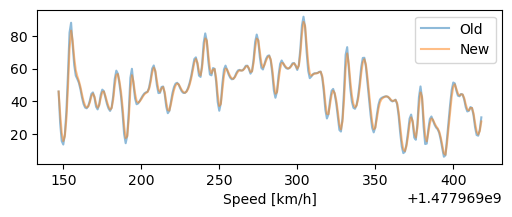

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,2))
trip_calculated = traj_calculated[traj_calculated['tripID'] == 0].copy()
trip_smoothed = traj_smoothed[traj_smoothed['tripID'] == 0].copy()
plt.plot(trip_calculated['time[s]'], trip_calculated['speed[km/h]'], label='Old', alpha=0.5)
plt.plot(trip_smoothed['time[s]'], trip_smoothed['speed[km/h]'], label='New', alpha=0.5)
plt.xlabel("Speed [km/h]")
plt.legend()
plt.show()

## 1.6 Filtering

Filtering is performed by the function `Preprocess.filter` which filters redundancy and samples exceeding a range of speed, acceleration and VSP.
- The default speed range is set to `[0, 150]` km/h.
- The default acc range is set to `[-4.4704, 6.25856]` m/s$^2$ ([-10, 10] mph/s).
- The default VSP range is set to `[-47.5, 62.5]` kW/t.

In [9]:
# set filter params
preprocessor.setParam(
    funcName='filter',
    paramDict={
        "minSpeed": 0,
        "maxSpeed": 150,
        "minAcc": -4.4704,
        "maxAcc": 6.25856,
        "minVSP": -47.5,
        "maxVSP": 62.5
    }
)

# perform filtering
traj_filtered = preprocessor.filter(traj_smoothed)

Filtering...
- filtered length: 2966;
- filtered ratio: 2.02%.


# 2 Pipe

We provide pipeline function to combine several operations in one procedure.

In [10]:
from preprocessing import Preprocess

# set parameters
encodeParam = {
    "colName": ['vehID', 'orderID', 'time[s]', 'lon', 'lat'],
    "encodingCol": ['vehID', 'orderID'],
    "sortBy": ['vehID', 'orderID', 'time[s]'],
    "originCRS": 'GCJ02'
}
filterParam = {"maxSpeed": 150}
segmentParam = {"segRefCol": 'orderID', "maxInterval": 6}
densifyParam = {"interpFunc": 'cubic'}
demPath = "./data/geo/AP_27359_FBS_F0600_RT1.dem.tif"
calculateParam = {"demPath": demPath}
smoothParam = {"smoothCol": ['speed[km/h]', 'acc[m/s2]', 'VSP[kW/t]'], "smoothFunc": 'exp'}

pre = Preprocess(
    encodeParam=encodeParam,
    filterParam=filterParam,
    segmentParam=segmentParam,
    densifyParam=densifyParam,
    calculateParam=calculateParam,
    smoothParam=smoothParam
)

# perform pipeline
traj = pre.pipe(raw, steps=['encode', 'segment', 'densify', 'calculate', 'smooth', 'filter'])
traj.head()

Encoding...
Segmenting...
- segmented trip amount: 12.


Densifying:   0%|          | 0/12 [00:00<?, ?it/s]

Densifying: 100%|██████████| 12/12 [00:00<00:00, 51.05it/s]


- densified length: 3050;
- densified ratio: 305.00%.
Calculating...


Smoothing: 100%|██████████| 11/11 [00:00<00:00, 687.64it/s]

Filtering...
- filtered length: 2963;
- filtered ratio: 2.11%.


,vehID,orderID,tripID,time[s],lon,lat,dist[km],interval[s],speed[km/h],acc[m/s2],ele[m],grade[D],VSP[kW/t]
1,0.0,0.0,0.0,1.477969e+09,104.070087,30.731888,0.007380,1.0,32.384281,-3.726804,466.000,0.000000,-34.847050
2,0.0,0.0,0.0,1.477969e+09,104.070087,30.731822,0.004364,1.0,20.712196,-1.527181,466.000,0.068639,-9.830153
3,0.0,0.0,0.0,1.477969e+09,104.070082,30.731783,0.003779,1.0,15.737670,0.747944,465.700,0.055508,3.349933
4,0.0,0.0,0.0,1.477969e+09,104.070070,30.731750,0.005502,1.0,18.587265,2.996978,465.490,0.026709,17.738155
5,0.0,0.0,0.0,1.477969e+09,104.070051,30.731704,0.009463,1.0,29.423483,5.278275,465.343,0.042550,50.495445


In [11]:
# traj.to_csv("./data/traj/sample_preprocessed.csv", index=False)

# Appendix A

The function `Preprocess.printDefautParam` helps you check defaut parameters in `Preprocess`.

In [11]:
preprocessor.printDefaultParam('encode')

colName: ['vehID', 'orderID', 'time[s]', 'lon', 'lat']
encodingCol: ['vehID', 'orderID']
sortBy: ['vehID', 'orderID', 'time[s]']
originCRS: GCJ02


In [12]:
preprocessor.printDefaultParam('filter')

intervalCol: interval[s]
speedCol: speed[km/h]
accCol: acc[m/s2]
VSPCol: VSP[kW/t]
minSpeed: 0
maxSpeed: 150
minAcc: -4.4704
maxAcc: 6.25856
minVSP: -47.5
maxVSP: 62.5


In [13]:
preprocessor.printDefaultParam('segment')

interval: True
segRefCol: orderID
timeCol: time[s]
tripIDColName: tripID
maxInterval: 6


In [14]:
preprocessor.printDefaultParam('densify')

timeCol: time[s]
tripIDCol: tripID
sortBy: ['vehID', 'tripID', 'time[s]']
lonCol: lon
latCol: lat
interpFunc: cubic


In [15]:
preprocessor.printDefaultParam('calculate')

demPath: None
tripIDCol: tripID
sortBy: ['vehID', 'tripID', 'time[s]']
dem: None
speed: True
acc: True
VSP: True
weight: 1.497
lonCol: lon
latCol: lat
timeCol: time[s]
distColName: dist[km]
intervalColName: interval[s]
speedColName: speed[km/h]
accColName: acc[m/s2]
gradeColName: grade[D]
VSPColName: VSP[kW/t]
calDirect: forward


In [16]:
preprocessor.printDefaultParam('smooth')

smoothCol: ['speed[km/h]', 'acc[m/s2]', 'VSP[kW/t]']
tripIDCol: tripID
smoothFunc: exp
